## 1. Prepare the environment

Optional: download all the python libraries if you not already present in the environment

In [2]:
! python.exe -m pip install --upgrade pip
! pip install --upgrade moku
! pip install zeroconf
%pip install --q moku[neuralnetwork]


Note: you may need to restart the kernel to use updated packages.


Import the Python libraries

In [3]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import moku
import numpy as np
import os
from pathlib import Path
from datetime import datetime
import time


In [4]:
from moku.instruments import MultiInstrument
from moku.instruments import WaveformGenerator, PIDController

try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed.")
    print("If you're running in a Notebook like Google Colab, uncomment the first line in this cell and run it again")
    print("Otherwise install the moku library with neural network extensions using `pip install moku[neuralnetwork]`")
    raise

List the available moku devices

In [5]:
! mokucli list

Name                 Serial  HW     FW     IP                  
---------------------------------------------------------------


## 2. Set up the Multi-instrument - data creation for training and testing datasets

In [6]:
def append_list_to_csv(data_list, filename):
    
    # Check if file exists
    file_exists = os.path.isfile(filename)
    print(file_exists)

    if not file_exists:
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(data_list)

    else:
        # Open the file in append mode
        with open(filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(data_list)

    

In [7]:
def save_data_to_csv(data_points, window_size, filename):
    # Ensure all values are floats
    data_points = [float(x) for x in data_points]

    # Compute total number of windows
    windows = []
    num_points = len(data_points)
    i = 0

    while i + window_size <= num_points:
        windows.append(data_points[i:i + window_size])
        i += window_size

    # Handle the last partial window
    if i < num_points:
        # Start the last window earlier to make it full size
        start = max(0, num_points - window_size)
        windows.append(data_points[start:num_points])

    # Check if file exists and read current ID count
    file_exists = os.path.exists(filename)
    next_id = 0
    if file_exists:
        with open(filename, mode='r', newline='') as file:
            reader = csv.reader(file)
            next(reader, None)  # Skip header
            next_id = sum(1 for _ in reader)

    # Open file in append mode (create if doesn't exist)
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)

        # Write header if file is new
        if not file_exists:
            writer.writerow(['id', 'data'])

        # Write each window
        for w in windows:
            writer.writerow([next_id, ';'.join(f'{x:.6f}' for x in w)])
            next_id += 1

    print(f"Total n. of frames in the output file: {next_id}")


Set up the instruments

### 2.2 Get the data from the PID controller and save it to local - FRAMES WITH ANOMALY

In [7]:
# Output filenames
output_folder = "AD_dataset/"
output_filename_anomaly = "data_anomaly_june"

timestamp = str(time.time()).split(".")[-1]

output_filename_anomaly = f"{output_folder}{output_filename_anomaly}_{timestamp}.csv"
print(f"Data will be saved in the file: {output_filename_anomaly}" )


# If the folder doesn't exist it, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Folder created: {output_folder}")
else:
    print(f"Folder already exists: {output_folder}")


Data will be saved in the file: AD_dataset/data_anomaly_june_2889826.csv
Folder already exists: AD_dataset/


In [8]:
# Replace in the code below the first input variable with your Moku IP adrress and platform id based on your Moku
m = MultiInstrument('10.1.119.245', platform_id=4, force_connect=True)

In [9]:
wg = m.set_instrument(1, WaveformGenerator)
pidc = m.set_instrument(2, PIDController)
wgmod = m.set_instrument(4, WaveformGenerator)

connections = [dict(source="Slot4OutA", destination="Slot1InA"),
                dict(source="Slot4OutB", destination="Slot1InB"),
                dict(source="Slot1OutA", destination="Slot2InA"),
                dict(source="Slot1OutB", destination="Slot2InB"),
                dict(source="Slot2OutA", destination="Output1")]

print(m.set_connections(connections=connections))

wg.generate_waveform(channel=1, type="Sine", frequency=400, amplitude=1.0)
wg.generate_waveform(channel=2, type='Noise', amplitude=1.0)
wg.set_modulation(channel=2, type="Amplitude", source="InputB", depth=1000)


# Try not to match the pulse glitch frequency with the sine wave's frequency or any of its multiplier
wgmod.generate_waveform(channel=2, type="Pulse", frequency=851, amplitude=1,
                        offset=410e-3, pulse_width=1e-6, edge_time=2e-9)

pidc.set_control_matrix(channel=1, input_gain1=1, input_gain2=20)
pidc.set_control_matrix(channel=2, input_gain1=0, input_gain2=0)


pidc.set_by_frequency(channel=1, prop_gain=0)
pidc.set_monitor(monitor_channel=2, source="Output1")
pidc.set_by_gain(channel=2, prop_gain=0)

# Enable the outputs of the PID controller
pidc.enable_output(1, signal=True, output=True)
pidc.enable_output(2, signal=True, output=False)
pidc.set_timebase(-15e-3, 15e-3)

[{'destination': 'Slot1InA', 'source': 'Slot4OutA'}, {'destination': 'Slot1InB', 'source': 'Slot4OutB'}, {'destination': 'Slot2InA', 'source': 'Slot1OutA'}, {'destination': 'Slot2InB', 'source': 'Slot1OutB'}, {'destination': 'Output1', 'source': 'Slot2OutA'}]


{'t1': -0.015, 't2': 0.015}

In [10]:
window_size = 100
n_frames = 10


In [11]:

for i in range(n_frames):
    data = pidc.get_data() # Get the data from the PID controller

    # Set up the plotting parameters
    '''plt.ion()
    plt.show()
    plt.grid(visible=True)
    plt.ylim([-1, 1])
    plt.xlim([data['time'][0], data['time'][-1]])

    line1, = plt.plot([])
    line2, = plt.plot([])

    # Configure labels for axes
    ax = plt.gca()

    # This loops continuously updates the plot with new data
   
    # Update the plot
    line1.set_ydata(data['ch1'])
    line2.set_ydata(data['ch2'])
    line1.set_xdata(data['time'])
    line2.set_xdata(data['time'])'''


    print(f'{i} - Saved {len(data["ch2"])} points from the PID controller')
    save_data_to_csv(data["ch2"],window_size, filename=output_filename_anomaly)


0 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 11
1 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 22
2 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 33
3 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 44
4 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 55
5 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 66
6 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 77
7 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 88
8 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 99
9 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 110


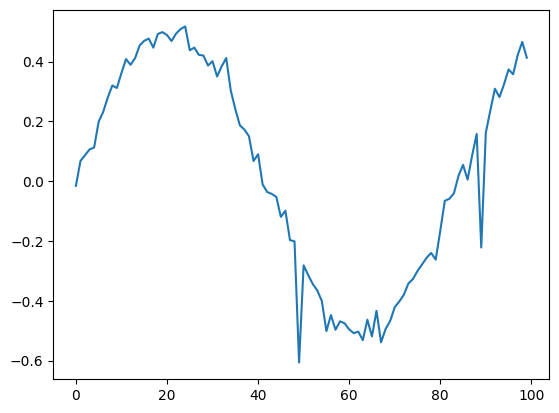

In [12]:
plt.plot(data['ch2'][:100])

### 2.3 Get the data from the PID controller and save it to local - NORMAL FRAMES

In [13]:
# Output filenames
output_folder = "AD_dataset/"
output_filename_normal = "data_normal_june"

timestamp = str(time.time()).split(".")[-1]

output_filename_normal = f"{output_folder}{output_filename_normal}_{timestamp}.csv"
print(f"Data will be saved in the file: {output_filename_normal}" )


# If the folder doesn't exist it, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Folder created: {output_folder}")
else:
    print(f"Folder already exists: {output_folder}")


Data will be saved in the file: AD_dataset/data_normal_june_3252609.csv
Folder already exists: AD_dataset/


In [14]:
wg = m.set_instrument(1, WaveformGenerator)
pidc = m.set_instrument(2, PIDController)

connections = [dict(source="Slot4OutB", destination="Slot1InB"),
                dict(source="Slot1OutA", destination="Slot2InA"),
                dict(source="Slot1OutB", destination="Slot2InB"),
                dict(source="Slot2OutA", destination="Output1")]

print(m.set_connections(connections=connections))

wg.generate_waveform(channel=1, type="Sine", frequency=400, amplitude=1.0)
wg.generate_waveform(channel=2, type='Noise', amplitude=1.0)
wg.set_modulation(channel=2, type="Amplitude", source="InputB", depth=1000)

pidc.set_control_matrix(channel=1, input_gain1=1, input_gain2=1)
pidc.set_control_matrix(channel=2, input_gain1=0, input_gain2=0)


pidc.set_by_frequency(channel=1, prop_gain=0)
pidc.set_monitor(monitor_channel=2, source="Output1")
pidc.set_by_gain(channel=2, prop_gain=0)

# Enable the outputs of the PID controller
pidc.enable_output(1, signal=True, output=True)
pidc.enable_output(2, signal=True, output=False)
pidc.set_timebase(-15e-3, 15e-3)

[{'destination': 'Slot1InA', 'source': 'Slot4OutA'}, {'destination': 'Slot1InB', 'source': 'Slot4OutB'}, {'destination': 'Slot2InA', 'source': 'Slot1OutA'}, {'destination': 'Slot2InB', 'source': 'Slot1OutB'}, {'destination': 'Output1', 'source': 'Slot2OutA'}]


{'t1': -0.015, 't2': 0.015}

In [15]:
window_size = 100
n_frames = 300

In [16]:

for i in range(n_frames):
    data = pidc.get_data() # Get the data from the PID controller

    print(f'{i} - Saved {len(data["ch2"])} points from the PID controller')
    save_data_to_csv(data["ch2"],window_size, filename=output_filename_normal)


0 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 11
1 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 22
2 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 33
3 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 44
4 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 55
5 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 66
6 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 77
7 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 88
8 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 99
9 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 110
10 - Saved 1024 points from the PID controller
Total n. of frames in the output file: 121
11 - Saved 1024 points from t

## 3. Compose the training dataset

In [8]:
def load_data_from_csv(filename):
    data_windows = []

    with open(filename, mode='r', newline='') as file:
        reader = csv.reader(file)
        header = next(reader, None)  # Skip header if it exists

        for row in reader:
            if len(row) < 2:
                continue  # Skip malformed rows
            # Split the 'data' field and convert back to floats
            float_values = [float(x) for x in row[1].split(';')]
            data_windows.append(float_values)

    return data_windows


In [9]:
# Read from the saved files
output_filename_anomaly = 'AD_dataset/data_anomaly_june_2889826.csv'
output_filename_normal = 'AD_dataset/data_normal_june_3252609.csv'
data_anomaly = load_data_from_csv(output_filename_anomaly)
data_normal = load_data_from_csv(output_filename_normal)

# Split into training and testing set
data_anomaly_frames = int(len(data_anomaly)*0.8)
data_anomaly_training = data_anomaly[:data_anomaly_frames]
data_anomaly_testing = data_anomaly[data_anomaly_frames:]

data_normal_frames = int(len(data_normal)*0.8)
data_normal_training = data_normal[:data_normal_frames]
data_normal_testing = data_normal[data_normal_frames:]


print(f"N. of frames with anomaly in the training dataset: {len(data_anomaly_training)}")
print(f"N. of normal frames in the training dataset: {len(data_normal_training)}")

print(f"N. of frames with anomaly in the testing dataset: {len(data_anomaly_testing)}")
print(f"N. of normal frames in the testing dataset: {len(data_normal_testing)}")

N. of frames with anomaly in the training dataset: 88
N. of normal frames in the training dataset: 2640
N. of frames with anomaly in the testing dataset: 22
N. of normal frames in the testing dataset: 660


In [10]:
full_training_dataset = data_anomaly_training + data_normal_training
print(f"Total number of frames in the training dataset: {len(full_training_dataset)}")

full_testing_dataset = data_anomaly_testing + data_normal_testing
print(f"Total number of frames in the testing dataset: {len(full_testing_dataset)}")

Total number of frames in the training dataset: 2728
Total number of frames in the testing dataset: 682


Split the training dataset into training and validation sets.
80/20 split is used in this tutorial.

In [11]:
train_size = int(0.8 * len(full_training_dataset))
val_size = len(full_training_dataset) - train_size

indices = list(range(len(full_training_dataset)))


# Split the indices into training and validation sets
train_indices = indices[:train_size]
val_indices = indices[train_size:]

print(f"Tot n. of frames in the training dataset: {train_size}")
print(f"Tot n. of frames in the validation dataset: {val_size}")

Tot n. of frames in the training dataset: 2182
Tot n. of frames in the validation dataset: 546


In [12]:
# Create train and validation datasets with the generated indices
training_inputs = [full_training_dataset[i] for i in train_indices]
validation_inputs = [full_training_dataset[i] for i in val_indices]



TO DO: check anomalies in both the val and training dataset

## 4. Define the model and train

In [50]:
quant_mod = LinnModel()

In [51]:
# Set up the early stopping - the below checks every 10 epochs 

early_stopping_config = {
    'patience': 10,   # Allow 10 epochs without improvement
    'restore_best_weights': True
}

In [52]:
# model definition for an autoencoder
frame_length = len(training_inputs[0])
print(f"frame length/input dimension: {frame_length}")

# train the model
quant_mod.set_training_data(training_inputs=training_inputs, training_outputs=training_inputs)
model_definition = [(64, 'tanh'), (32, 'tanh'), (16, 'tanh'), (frame_length, 'linear')]

# build the model
#quant_mod.construct_model(model_definition, show_summary=True)
quant_mod.construct_model(model_definition)

frame length/input dimension: 100


In [53]:
history = quant_mod.fit_model(epochs=100, es_config=early_stopping_config, validation_split=0.1)

Value for monitor missing. Using default:val_loss.
Value for restore missing. Using default:False.


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3641 - val_loss: 0.1037
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0643 - val_loss: 0.0085
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062 - val_loss: 0.0021
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 9.4555e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 5.2216e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1463e-04 - val_loss: 3.2842e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0027e-04 - val_loss: 2.3276e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1626e-04 - val_loss: 1.8471e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0839e-04 - val_loss: 1.5169e-04
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2872e-04 - val_loss: 1.2653e-04
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0409e-04 - val_loss: 1.0702e-04
Epoch 1

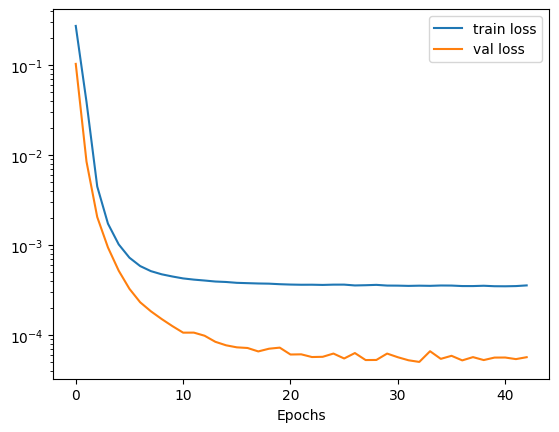

In [54]:
# plot the losses
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('Epochs')
plt.show()

In [55]:
model_filename = 'AD_model_june_tanh.linn'
T = np.linspace(-1, 1, 100)
save_linn(quant_mod, input_channels=1, output_channels=1, file_name=model_filename, output_mapping=[T.size-1])

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 224 cycles


In [56]:
import os

print(os.getcwd())

c:\Users\miche\OneDrive\Documents\nn_git\moku-examples\neural-network\Anomaly_Detection\precision_api


# 5. Testing the model - reconstruct the training dataset
This is used to see how well the model has learnt to reconstruct the data from the training dataset

In [57]:
reconstructions = []
reconstructions = quant_mod.predict(full_training_dataset)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


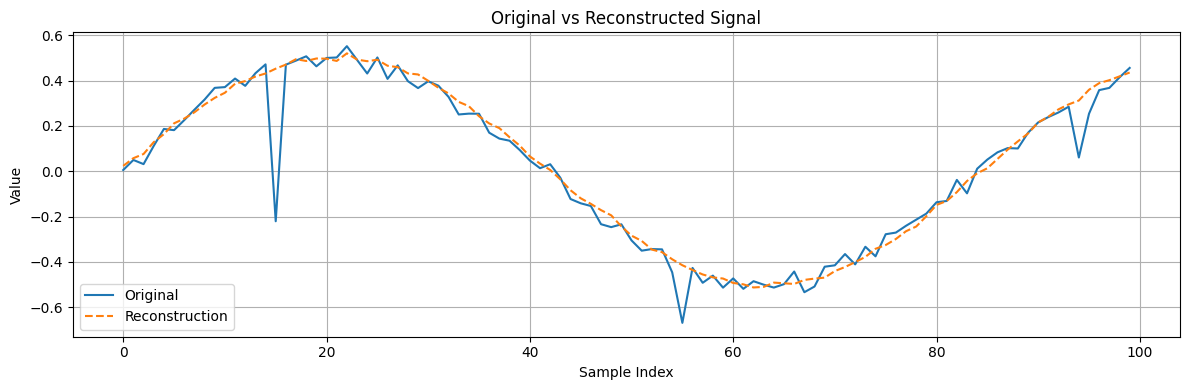

In [58]:
frame_id_nomral = 0

plt.figure(figsize=(12, 4))
plt.plot(full_training_dataset[frame_id_nomral], label='Original')
plt.plot(reconstructions[frame_id_nomral], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


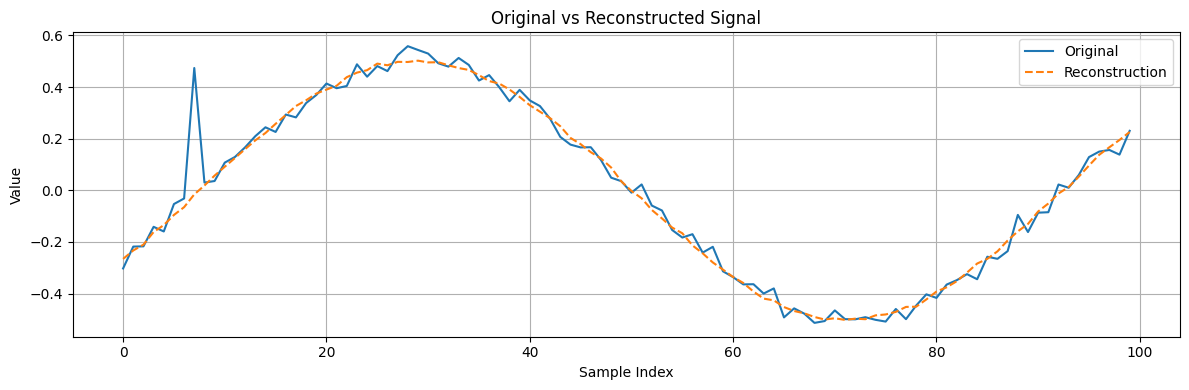

In [59]:
frame_id_anomaly = 10

plt.figure(figsize=(12, 4))
plt.plot(full_training_dataset[frame_id_anomaly], label='Original')
plt.plot(reconstructions[frame_id_anomaly], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


# 6. Testing the model - reconstruct the testing dataset
This is used to see how well the model generalize the signal reconstruction on never seens before waveforms.

In [60]:
reconstructions_test = []
reconstructions_test = quant_mod.predict(full_testing_dataset)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


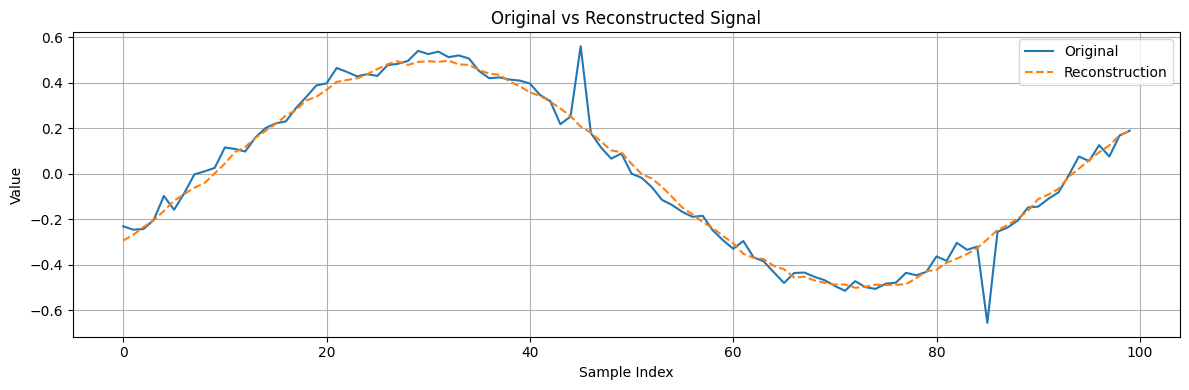

In [61]:
frame_id_anomaly_test = 10

plt.figure(figsize=(12, 4))
plt.plot(full_testing_dataset[frame_id_anomaly_test], label='Original')
plt.plot(reconstructions_test[frame_id_anomaly_test], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


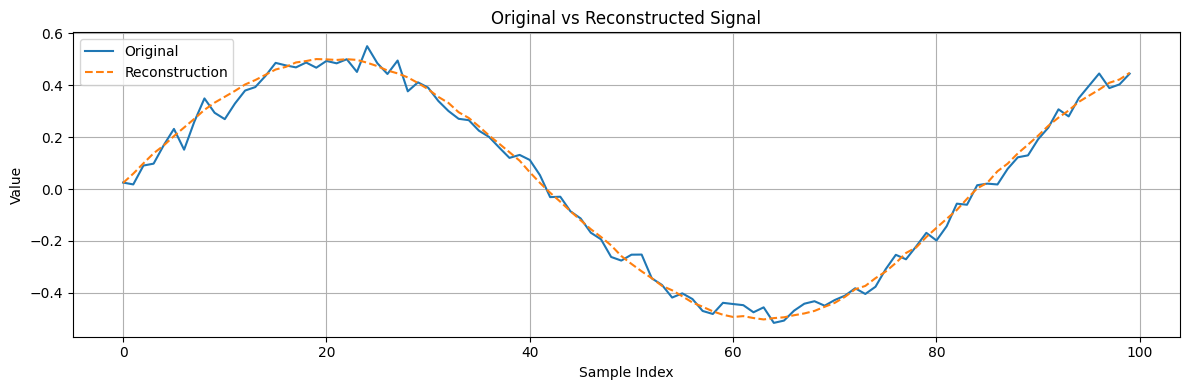

In [62]:
frame_id_normal_test = 0

plt.figure(figsize=(12, 4))
plt.plot(full_testing_dataset[frame_id_normal_test], label='Original')
plt.plot(reconstructions_test[frame_id_normal_test], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


# 7. Extract the reconstruction error

In [63]:
original = np.array(full_testing_dataset)
reconstructed = np.array(reconstructions_test)

# --- Error Calculations ---
# Element-wise absolute error
absolute_error = np.abs(original - reconstructed)

# Element-wise squared error
squared_error = (original - reconstructed) ** 2

# Total error per sample (row-wise)
absolute_error_per_frame = absolute_error.sum(axis=1)
squared_error_per_frame = squared_error.sum(axis=1)


#### Absolute error

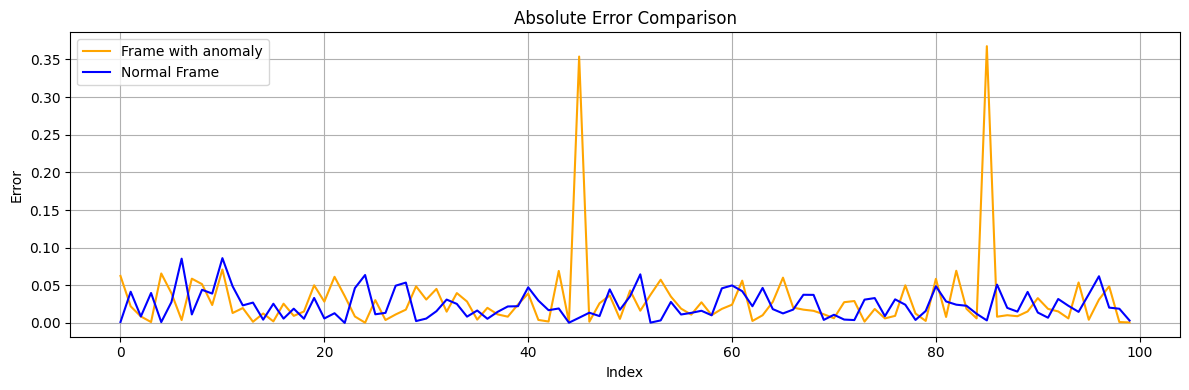

In [64]:
# --- Plotting both frame_ids together ---
plt.figure(figsize=(12, 4))

plt.plot(absolute_error[frame_id_anomaly_test], label='Frame with anomaly', color='orange')
plt.plot(absolute_error[frame_id_normal_test], label='Normal Frame', color='blue')

plt.title('Absolute Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
threshold = 0.15

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(absolute_error[frame_id_anomaly_test]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [absolute_error[frame_id_anomaly_test][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(absolute_error[frame_id_normal_test]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [absolute_error[frame_id_normal_test][i] for i in indices])

Frame with anomaly
Indices of values > threshold: [45, 85]
Corresponding values: [np.float64(0.3539090131874084), np.float64(0.36769402456092837)]
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []


#### Squared error

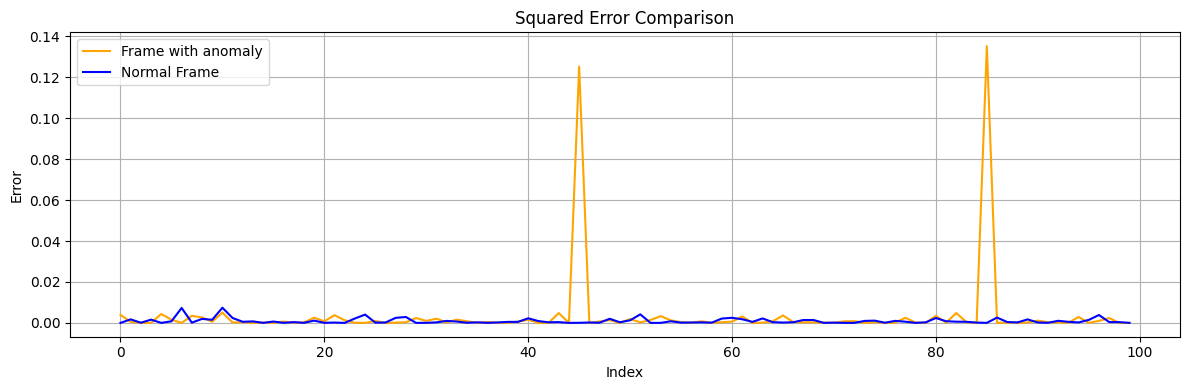

In [66]:
plt.figure(figsize=(12, 4))

plt.plot(squared_error[frame_id_anomaly_test], label='Frame with anomaly', color='orange')
plt.plot(squared_error[frame_id_normal_test], label='Normal Frame', color='blue')

plt.title('Squared Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
threshold = 0.015

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(squared_error[frame_id_anomaly_test]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [squared_error[frame_id_anomaly_test][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(squared_error[frame_id_normal_test]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [squared_error[frame_id_normal_test][i] for i in indices])

Frame with anomaly
Indices of values > threshold: [45, 85]
Corresponding values: [np.float64(0.12525158961528524), np.float64(0.1351988956978126)]
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []


### Focal loss

In [68]:
def focal_mse_loss(prediction, target, gamma=2.5):
    error = prediction - target
    squared_error = error ** 2
    loss = squared_error ** gamma
    return loss

In [47]:
# --- Focal Loss Calculation ---
focal_loss = focal_mse_loss(reconstructed, original)  # element-wise focal loss

# Total focal loss per sample (row-wise sum)
focal_loss_per_frame = focal_loss.sum(axis=1)

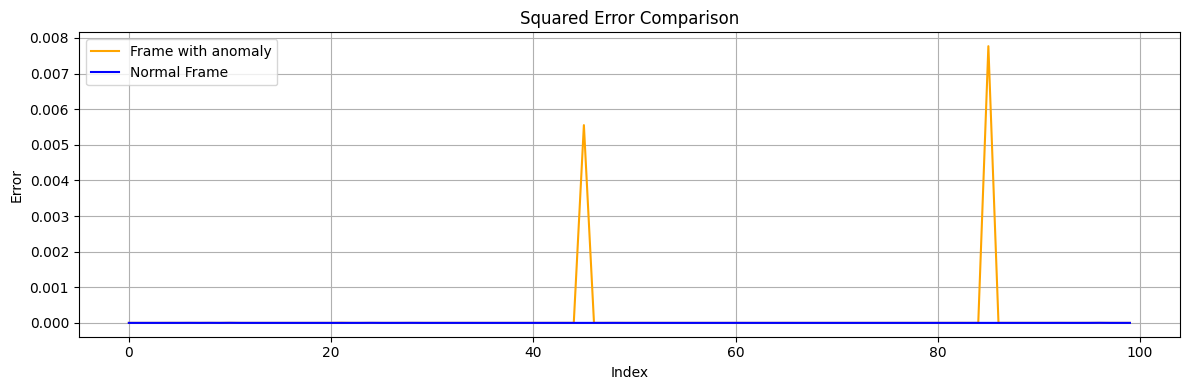

In [48]:

plt.figure(figsize=(12, 4))

plt.plot(focal_loss[frame_id_anomaly_test], label='Frame with anomaly', color='orange')
plt.plot(focal_loss[frame_id_normal_test], label='Normal Frame', color='blue')

plt.title('Squared Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
threshold = 0.00008

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id_anomaly_test]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id_anomaly_test][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id_normal_test]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id_normal_test][i] for i in indices])

Frame with anomaly
Indices of values > threshold: [45, 85]
Corresponding values: [np.float64(0.005550923246604065), np.float64(0.007767271527880814)]
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []
